In [22]:
import yfinance as yf
import pandas as pd
# pip install yfinance
from pprint import pprint
from pandas_profiling import ProfileReport
import numpy as np
import scipy.stats as st
import plotly.graph_objects as go # for candle chart # next round future
import matplotlib.pyplot as plt
from datetime import datetime # convert timestamp and revese to string
%matplotlib inline
import quantstats as qs


# Time Handler function()1

In [23]:
# from datetime import datetime
def dftimeStaptoString(df):
    df.index.strftime("%Y-%m-%d")
    return df

# Time Handler function()2

In [24]:
def timeHandlerFC(df):
    df=df.assign(year=df.index.year, month=df.index.month,day=df.index.day)
    return df

# DataFrame Time Slicer

In [25]:
# study the index for and datetime libaray
def dataFrameYrselectionFC(df,time):
    df=df.loc[df.index>=time]
    return df

In [26]:
SpyTrimmed2020=SPYadj.copy()
SpyTrimmed2020=dataFrameYrselectionFC(df=SpyTrimmed2020,time='2020-01-01')
SpyTrimmed2020
#perfect just like that, now we can manupulate any time we wanna with lots angels

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,311.117065,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,308.761200,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,309.939087,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,309.067627,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,310.714844,68296000
...,...,...,...,...,...,...
2022-11-28,399.089996,400.809998,395.109985,395.910004,395.910004,67881600
2022-11-29,396.049988,397.299988,393.299988,395.230011,395.230011,52310000
2022-11-30,395.489990,407.679993,393.480011,407.679993,407.679993,144566700


# Build VolumeOverPriceTool

In [27]:
# df:dataframe from yfinance
#x price interval for underlying price
#n slicer where interval start
#m slicer where interval end
# it build analysis base on close price and sum of the history vloume over price
# seek to find the signficance of price that interpreted by volume
def volumeonPriceintervalFC(df,x,n,m):
    binn=np.arange(0,480,x).tolist()
    result=pd.cut(df['Close'],bins=binn)
    df['Range']=result
    fm=df.groupby(['Range']).sum()['Volume'][n:m]  
    gp=fm.plot(kind='bar')
    return gp,fm
    
    

# Caculate rate of changes

In [28]:
# notice a good way to understand how it work is to write a function.


# Caculate Log Return

# Build Graphic Generator

In [29]:
# note input has to be us stock ticker a commpany wiht ""; eg input="SPY"
# start/end date has to be "YYYY-MM-DD" format
def givemeachart(input,start,end): # is this the dependency not within the function?# notice need to put diff quotation on it
    ticker=yf.Ticker(input)
    Fetched=ticker.history(start=start,end=end)
    plt.figure(figsize=(10,6))
    performance=plt.plot(Fetched['Close'])
    plt.grid()
    plt.show()
# looking for the documentary to define the functions

# Down Load the SPY Data Frame

In [30]:
# While closing price merely refers to the cost of shares at the end of the day, 
#the adjusted closing price considers other factors like dividends, stock splits,
#and new stock offerings. Since the adjusted closing price begins where the closing price ends,
#it can be called a more accurate measure of stocks' value.
SPYadj=yf.download("SPY")
SPYadj

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.334009,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.514221,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.568268,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.838526,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.946657,531500
...,...,...,...,...,...,...
2022-11-28,399.089996,400.809998,395.109985,395.910004,395.910004,67881600
2022-11-29,396.049988,397.299988,393.299988,395.230011,395.230011,52310000
2022-11-30,395.489990,407.679993,393.480011,407.679993,407.679993,144566700


In [31]:
SPYadj.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7517 entries, 1993-01-29 to 2022-12-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       7517 non-null   float64
 1   High       7517 non-null   float64
 2   Low        7517 non-null   float64
 3   Close      7517 non-null   float64
 4   Adj Close  7517 non-null   float64
 5   Volume     7517 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 411.1 KB


In [32]:
#None Null data, good quality 
SPYadj.dropna()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.334009,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.514221,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.568268,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.838526,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.946657,531500
...,...,...,...,...,...,...
2022-11-28,399.089996,400.809998,395.109985,395.910004,395.910004,67881600
2022-11-29,396.049988,397.299988,393.299988,395.230011,395.230011,52310000
2022-11-30,395.489990,407.679993,393.480011,407.679993,407.679993,144566700


# Day counts up
   

In [20]:
# we can consider add display to make it side by side
def consecutiveupdistributionFC(df):
    L=df['Adj Close'].tolist()
    dayupdistribution=[]
    adjcloseprior=L[0]
    count=0
    for x in range(len(L)-1):
        if L[x+1]>L[x]:
            count=count+1
        else:
            dayupdistribution.append(count)
            count=0
    dayupdistribution
    daycountdistributiondf=pd.DataFrame({"daycountoccurance":dayupdistribution})
    daycountdistributiondf["Occurance"]=0
    consecutiveupdstribution=daycountdistributiondf.groupby(['daycountoccurance']).count()
    consecutiveupdstribution
    gp=consecutiveupdstribution.plot(kind='bar')
    return consecutiveupdstribution,gp
    

(                   Occurance
 daycountoccurance           
 0                       1551
 1                        908
 2                        450
 3                        284
 4                        140
 5                         71
 6                         32
 7                         17
 8                         13
 9                          2
 11                         1
 12                         1
 14                         1,
 <AxesSubplot:xlabel='daycountoccurance'>)

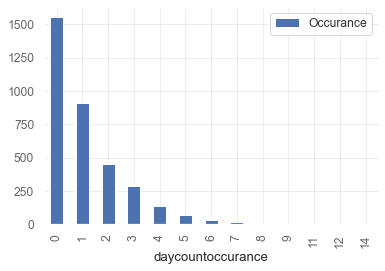

In [21]:
# since it is binary event the distribution itself is selfexplantary; potential catched a meanreversal strategy 
L=[]
consecutiveupdistributionFC(df=SPYadj)

In [ ]:
adjcloseprior=SPYadj['Adj Close'][0]
adjcloseprior

In [ ]:
(SPYadj['Adj Close'][1:]).tolist()

In [ ]:
# note start only configure the count start number of index, it always give out the full sets
L=SPYadj['Adj Close'].tolist()
dayupdistribution=[]
adjcloseprior=L[0]
count=0
for x in range(len(L)-1):
    if L[x+1]>L[x]:
        count=count+1
#         print(count)
    else:
        dayupdistribution.append(count)
        count=0
        
dayupdistribution
daycountdistributiondf=pd.DataFrame({"daycountoccurance":dayupdistribution})
daycountdistributiondf["helperoll"]=0
consecutiveupdstribution=daycountdistributiondf.groupby(['daycountoccurance']).count()
consecutiveupdstribution


In [ ]:
consecutiveupdstribution.plot(kind='bar')

In [ ]:
f

In [ ]:
#https://www.vanguard.ca/en/advisor/products/products-group/etfs/VCN
CADadj=yf.download("VCN")
CADadj

In [ ]:
CADadj=yf.download("FTSE",period='40')
CADadj

# US vs Rest of the Word?

In [ ]:
#https://etfdb.com/index/msci-all-country-world-index-ex-usa/
restWord=yf.download("ACWX")
restWord

## add FRED API ? https://fred.stlouisfed.org/docs/api/fred/   \
## add TA-LIB for bollinger bands?


In [ ]:
qs.extend_pandas() # this is required to pass quantstat to Jupyter

In [ ]:
spyqt=qs.utils.download_returns('SPY')
spyqt

In [ ]:
#Calculate Sharp
qs.stats.sharpe(spyqt)

In [ ]:
spyqt.cagr()

In [ ]:
spyqt.plot_drawdown()

In [ ]:
spyqt.plot_distribution()

In [ ]:
spyqt.plot_drawdowns_periods()

In [ ]:
spyqt.monthly_returns()

In [ ]:
spyqt.plot_monthly_heatmap()

In [ ]:
spyqt.max_drawdown()

In [ ]:
#qs.reports.html(spyqt,output='fileloaction/spyreport.html')
qs.reports.plots(spyqt) # we can save as internet link format as well 

In [ ]:
spyqt.plot_earnings(start_balance=10000) # once qs pandas extend initiate all additional function rdy
# (savefig='filelocation') --can save the graph for ppt

In [ ]:
tickers={"SSO":0.3,"GOF":0.2,"BRW":0.2,"TLT":0.3}
profo=qs.utils.make_index(tickers)
qs.reports.html(profo,'SPY',output="profo.html")

In [ ]:
SPYadj.info()

In [ ]:
SPYadj.dropna()

In [ ]:
# note checked the time of data is time-stamp; hence it will be way easier to convert UTC format
SPYadj.index[0]

In [ ]:
SPYadj.assign(year=SPYadj.index.year, month=SPYadj.index.month,day=SPYadj.index.day)

In [ ]:
SPYadj.reset_index()

In [ ]:
split("1993-01-29",'-')

In [ ]:
fig=go.Figure(data=[go.Candlestick(x=SPYadj['Date'],open=SPYadj['Open'],high=SPYadj['High'],low=SPYadj['Low'],
                                  close=SPYadj['close'])
                 

In [ ]:
volumeonPriceintervalFC(df=SPYadj,x=1,n=380,m=400)

In [ ]:
var_spymaxperiod=np.var(SPYadj['Adj Close'])
std_spymaxperiod=np.std(SPYadj['Adj Close'])
mean_spymaxperiod=np.mean(SPYadj['Adj Close'])

In [ ]:
print(f"Roughly 68% among {mean_spymaxperiod-std_spymaxperiod*1} and {mean_spymaxperiod+std_spymaxperiod*1}")
print(f"Roughly 95% among {(mean_spymaxperiod-std_spymaxperiod*2)} and {mean_spymaxperiod+std_spymaxperiod*2}")
print(f"Roughly 99.7% among {mean_spymaxperiod-std_spymaxperiod*3} and {mean_spymaxperiod+std_spymaxperiod*3}")

In [ ]:
print(f"Roughly 68% among {mean_spymaxperiod-std_spymaxperiod*1} and {mean_spymaxperiod+std_spymaxperiod*1}")
print(f"Roughly 95% among 0 and {mean_spymaxperiod+std_spymaxperiod*2}")
print(f"Roughly 99.7% among 0 and {mean_spymaxperiod+std_spymaxperiod*3}")

In [ ]:
st.normaltest(SPYadj['Adj Close'].sample(1000))

In [ ]:
zSpyMaxperiod=st.zscore(SPYadj['Adj Close'])

In [ ]:
spy=yf.Ticker('SPY')
type(spy)

In [ ]:
spy.info

In [ ]:
spy.splits

In [ ]:
spy.info.keys() # show higher level frame, see what we can do about it

In [ ]:
# clean data
# deal with time serials of data

In [ ]:
spy.institutional_holders

In [ ]:
spy.earnings_history # need to fetch from bloomberg?

In [ ]:
FetchedSpy=spy.history(period='max')

In [ ]:
print(spy.history(period='max'))

In [ ]:
FetchedSpy.to_csv("SPYoutPut.csv")

In [ ]:
df=spy.dividends
df


In [ ]:
pprint(spy.info)

In [ ]:
IndexPE=spy.info['equityHoldings']['priceToEarnings']
IndexPE

In [ ]:
# for key,value in stockinfo.items():
#    print(key,':',value)
df=spy.dividends
dff=df.to_frame()
dff

In [ ]:
dir(df) # study these method for fun?

In [ ]:
data=df.resample('Y').sum()
data

In [ ]:
dff2=dff.reset_index()['Date'].dt.year # try how to split them further
dff2

In [ ]:
FetchedSpy

In [ ]:
FetchedSpy.shift(1)

In [ ]:
FetchedSpy.describe()

In [ ]:
FetchedSpy['Close'].max()

In [ ]:
volumefeedMaxperiod=FetchedSpy.groupby(['Close']).sum()['Volume']
volumefeedMaxperiod=volumefeedMaxperiod.reset_index()
volumefeedMaxperiod

In [ ]:
pricingbin=[0,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475]
labels=["0~25","25~50","50~75","75~100","100~125","125~150","150~175","175~200","200~225","225~250",
      "250~275","275~300","300~325","325~350","350~375","375~400","400~425","425~450","450~int(FetchedSpy['Close'].max())"]
volumeOverpricelabels=pd.cut(volumefeedMaxperiod['Close'],bins=pricingbin)
volumeOverpricelabels

In [ ]:
volumefeedMaxperiod['StockRange']=volumeOverpricelabels
volumefeedMaxperiod

In [ ]:
pricevolumeforPlot=volumefeedMaxperiod.groupby(['StockRange']).sum()['Volume']
pricevolumeforPlot.plot(kind='bar')

In [ ]:
FetchedSpy['Volume'].plot() 

In [ ]:
closerlookvolume=pricevolumeforPlot.loc[pricevolumeforPlot.index[10:]]
closerlookvolume.plot(kind='bar')


In [ ]:
byunit10=np.linspace(start=0,stop=480,num=49)
byunit10

In [ ]:
FetchedSpy

In [ ]:
np.arange(0,480,1)

In [ ]:
FetchedSpy

In [ ]:
FetchedSpy

In [ ]:
def volumeonPriceintervalFC(df,x,n,m):
    binn=np.arange(0,480,x).tolist()
    result=pd.cut(df['Close'],bins=binn)
    df['Range']=result
    fm=df.groupby(['Range']).sum()['Volume'][n:m]  
    gp=fm.plot(kind='bar')
    return gp
    

In [ ]:
volumeonPriceintervalFC(df=FetchedSpy,x=1,n=450,m=480)

In [ ]:
type(FetchedSpy['Volume'][0])

In [ ]:
binn=np.arange(25,480,3).tolist()
binn
result=pd.cut(FetchedSpy['Close'],bins=binn)
result
FetchedSpy['Range']=result
plott=FetchedSpy.groupby(['Range']).sum()['Volume'][130:]
plott.plot(kind='bar')

In [ ]:
labelsBY5=[]

In [ ]:
volumeOverpricelabelsbyUnit10=pd.cut(volumefeedMaxperiod['Close'],bins=byunit10)
volumeOverpricelabelsbyUnit10

In [ ]:
volumeOverpricelabelsbyUnit10df=volumefeedMaxperiod.copy()
volumeOverpricelabelsbyUnit10df['StockRange']=volumeOverpricelabelsbyUnit10
volumeOverpricelabelsbyUnit10df

In [ ]:
voulumeoverPriceUnit10=volumeOverpricelabelsbyUnit10df.groupby(["StockRange"]).sum()['Volume']
voulumeoverPriceUnit10.plot(kind='bar')

In [ ]:
len(voulumeoverPriceUnit10)

In [ ]:
closerlookunitby10graph=voulumeoverPriceUnit10[30:].plot(kind="bar")

In [ ]:

volumeOverpricelabelsbyUnit10=pd.cut(volumefeedMaxperiod['Close'],bins=byunit10)

In [ ]:
#looking closer


In [ ]:
df2022=spy.history(start='2022-01-01',end='2022-12-30', rounding=True) # note here rounding =true to give to cents
df2022

In [ ]:
profileMaxPeriod=ProfileReport(FetchedSpy,title="MaxPeriodReport")
profileMaxPeriod

In [ ]:
import matplotlib.pyplot as plt

In [ ]:

plt.figure(figsize=(10,6))
performance=plt.plot(FetchedSpy['Close'])
plt.grid()
plt.show()

In [ ]:
def givemeachart(input,start,end): # is this the dependency not within the function?# notice need to put diff quotation on it
    ticker=yf.Ticker(input)
    Fetched=ticker.history(start=start,end=end)
    plt.figure(figsize=(10,6))
    performance=plt.plot(Fetched['Close'])
    plt.grid()
    plt.show()
# looking for the documentary to define the functions

In [ ]:
graph2022=givemeachart("de",'2022-01-01','2022-12-30')

In [ ]:
graphTqqq=givemeachart("TQQQ",'2022-01-01','2022-12-30')

In [ ]:
Bitcoin=givemeachart('BTC-USD','2022-01-01','2022-12-30')

In [ ]:
#faster way to do things
# from pandas_datareader import data as pdr

# import yfinance as yf
# yf.pdr_override() # <== that's all it takes :-)

# # download dataframe
# data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")

In [ ]:
# note we can request the data from yahoo finace by per minutes
qqq=yf.Ticker('QQQ')
df=qqq.history(period='max',actions=False,rounding=True,interval='15m')
df

In [ ]:
df15min=qqq.history(period='60d',actions=False,rounding=True,interval='15m',prepost=False)
df15min

In [ ]:
df15min=qqq.history(period='60d',actions=False,rounding=True,interval='15m',prepost=False,start="2022-12-01",end='2022-01-01')
df15min

In [ ]:
df15min=qqq.history(period='60d',actions=False,rounding=True,interval='15m',prepost=False)
df15min

In [ ]:
df15min.info()

In [ ]:
# note it give the index loop through time

In [ ]:
#discover it is a 
type(df15min.copy().reset_index()['Datetime'][0])

In [ ]:
4
# stack overflow

# First, make sure your TIMESTAMP column is a datetime instead of a string (e.g. df['TIMESTAMP'] = pd.to_datetime(df.TIMESTAMP)).

# Next, use this column as the index of the dataframe. To make this permanent, df.set_index('TIMESTAMP, inplace=True)`.

# Now you can resample for any given frequency (e.g. 30min) and use different methods of aggregation such as sum, mean (the default), a lambda function, etc).

# Optionally, you can add .fillna(0) to replace the NaNs with zeros.

In [ ]:
ploTSeries=df15min['Close']
ploTSeries

In [ ]:
plt.figure(figsize=(8,5))
ploTSeries.plot(title='QQQ15min')

In [ ]:
YMDformatSPYadj

In [ ]:
howmanydayfromtoday=(np.arange(0,len(YMDformatSPYadj))+1).tolist()
howmanydayfromtoday=howmanydayfromtoday[::-1]
howmanydayfromtoday# no we can construct it for the day we wanna

In [ ]:
YMDformatSPYadj['Retriveday']=howmanydayfromtoday
Yeartodayframe=YMDformatSPYadj.sort_values(by='Retriveday',ascending=True)
Yeartodayframe

In [ ]:
resetdf=YMDformatSPYadj.reset_index()
resetdf

In [ ]:
spy=yf.Ticker('SPY')
type(spy)

In [ ]:
time in df.reset_index()['Date'] if 

In [ ]:
finalize15min=[]
for i,day in enumerate(Yeartodayframe.reset_index()['Date'],start=1):
#          print(i,day)
    if (i%60==0 & i>=59):
        start=resetdf.iloc[i-59,0].strftime("%Y-%m-%d")
        end=resetdf.iloc[i,0].strftime("%Y-%m-%d")
        df=spy.history(start=start,end=end,actions=False,rounding=True,interval='15m',prepost=False)
        #?loop through df append each raw
        #? append each columns to list and let overwrite?
        #any better way to do ?D

        


        
        


# df15mins=spy.history(start='2022-10-30',end='2022-11-30',actions=False,rounding=True,interval='15m',prepost=False)
# df15mins

In [ ]:
df15mins=qqq.history(period="90d",actions=False,rounding=True,interval='15m',prepost=False)

In [ ]:
current_date=datetime.now()
current_date

In [ ]:
df15mins.index.strftime("%Y-%m-%d")[0]

In [ ]:
# lower level data for deeper loop, can be start data=x x from a range listed

# Option Section

In [ ]:
Experisionlist=spy.options
Experisionlist

In [ ]:
Experisionlist[0]

In [ ]:
puts=options.puts
puts

In [ ]:
options.calls.info()

In [ ]:
options.puts.info()

In [ ]:

for index,price in enumerate(c):
    if ((price%10==0) & (price>=10)):
        labelsBY5.append(f"less than {price}")
labelsBY5
    
        
           


            
        